In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [29]:
samples = set(
    [
        "cerebellum",
        "forebrain",
        "heart",
        "hindbrain",
        "intestine",
        "kidney",
        "liver",
        "lung",
        "midbrain",
        "stomach",
        "thymus"
    ]
)
print(sorted(samples))

['cerebellum', 'forebrain', 'heart', 'hindbrain', 'intestine', 'kidney', 'liver', 'lung', 'midbrain', 'stomach', 'thymus']


In [15]:
df = pd.read_csv("./CTCF-fwd/pos_seqs.forebrain.txt.gz", compression="gzip")
#neg = np.loadtxt("./CTCF-rc/neg_seqs.forebrain.txt.gz")
pos_scores = np.array(df[["Fwd", "Rev"]].max(axis=1).to_list())
pos_scores

array([0.9986104 , 0.91747844, 0.9981187 , ..., 0.99999475, 0.99995506,
       0.9999504 ])

In [16]:
#######################################################
# (*) Positive sequences are CTCF ChIP-seq regions in #
#     which the peak max overlaps an open region      #
# (*) Negative sequences are open regions that do not #
#     overlap a CTCF ChIP-seq region                  #
#######################################################

# Initialize
dfs = {}

for sample in sorted(samples):

    # Initialize
    data = []
    scores = []
    labels = []

    # Load positives
    df = pd.read_csv("./CTCF-fwd/pos_seqs.%s.txt.gz" % sample, compression="gzip")
    pos = df[["Fwd", "Rev"]].max(axis=1)
    print("total positives for %s is: %s" % (sample, len(pos)))
    scores.extend(pos.tolist())
    labels.extend(np.ones(len(pos)).tolist())

    # Load negatives
    df = pd.read_csv("./CTCF-fwd/neg_seqs.%s.txt.gz" % sample, compression="gzip")
    neg = df[["Fwd", "Rev"]].max(axis=1)
    print("total negatives for %s is: %s" % (sample, len(neg)))
    scores.extend(neg.tolist())
    labels.extend(np.zeros(len(neg)).tolist())

    # Create data frame
    dfs.setdefault(sample, pd.DataFrame(zip(scores, labels), columns=["Scores", "Labels"]))

total positives for cerebellum is: 24718
total negatives for cerebellum is: 320500
total positives for forebrain is: 45456
total negatives for forebrain is: 1320357
total positives for heart is: 71510
total negatives for heart is: 1145678
total positives for hindbrain is: 50508
total negatives for hindbrain is: 1248202
total positives for intestine is: 35313
total negatives for intestine is: 782567
total positives for kidney is: 79074
total negatives for kidney is: 688653
total positives for liver is: 125073
total negatives for liver is: 2472554
total positives for lung is: 126933
total negatives for lung is: 1010006
total positives for midbrain is: 52927
total negatives for midbrain is: 1604121
total positives for stomach is: 37654
total negatives for stomach is: 232830
total positives for thymus is: 16315
total negatives for thymus is: 452666


In [17]:
# i.e. Sanity check
print(dfs["heart"])

           Scores  Labels
0        0.999992     1.0
1        1.000000     1.0
2        0.998696     1.0
3        0.999989     1.0
4        0.999998     1.0
...           ...     ...
1217183  0.008095     0.0
1217184  0.006971     0.0
1217185  0.089668     0.0
1217186  0.000160     0.0
1217187  0.000433     0.0

[1217188 rows x 2 columns]


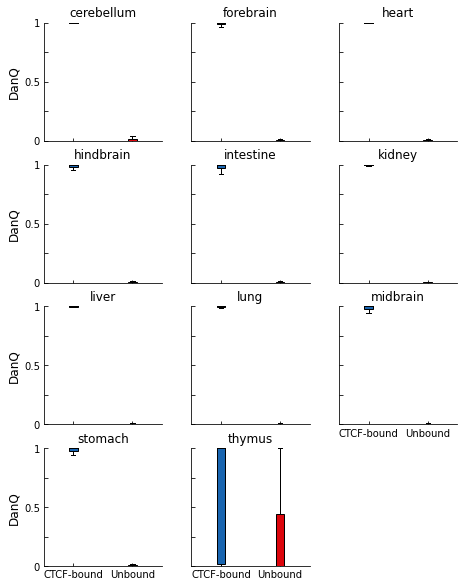

In [27]:
# Initialize
subplt = 0
colors = ["#1965B0", "#DC050C"]
labels = ["CTCF-bound", "Unbound"]
# Final submission | Naturewww.nature.com › for authors
# For guidance, Nature's standard figure sizes are 89 mm wide (single column) and 183 mm wide (double column).
# The full depth of a Nature page is 247 mm.
figsize = (7.20472, )
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(7.5, 10))
font_main = dict(size=12)
font_title = dict(size=12, color="black", weight="normal", verticalalignment="bottom")
boxprops = dict(linewidth=1, color="black")
capprops = dict(linewidth=1, color="black")
flierprops = dict(marker="o", markerfacecolor="black", markersize=1, linestyle="none")
medianprops = dict(linewidth=1, color="black")
whiskerprops = dict(linestyle="-", linewidth=1, color="black")

# Last ax is unnecessary
axes[-1, -1].axis("off")

# For each sample
for sample in sorted(dfs):

    # Get current ax
    data = []
    subplt += 1
    row = int((subplt-1) / 3)
    col = (subplt-1) - (3 * row)
    ax = axes[row, col]

    # Get data
    df = dfs[sample]
    data.append(df[df.Labels == 1.].Scores.tolist())
    data.append(df[df.Labels == 0.].Scores.tolist())
    data = np.array(data, dtype=object)

    # Boxplot
    boxes = ax.boxplot(data, labels=labels, patch_artist=True, showfliers=False, boxprops=boxprops, capprops=capprops,
        flierprops=None, medianprops=medianprops, whiskerprops=whiskerprops)

    # Color boxes
    for patch, color in zip(boxes["boxes"], colors):
        patch.set_facecolor(color)

    # Set title
    ax.set_title(sample, **font_title)
    ax.title.set_position([.5, .975])

    # Set y limit & ticks
    ax.set(ylim=(0., 1.))
    ax.set_yticks([0., .25, .5, .75, 1.])

    # Set x/y tick labels
    if subplt < 9:
        ax.set_xticklabels(["", ""])
    if col == 0:
        ax.set_yticklabels(["0", "", "0.5", "", "1"])
        ax.set_ylabel("DanQ", **font_main)
    else:
        ax.set_yticklabels(["", "", "", "", ""])
    ax.tick_params(direction="in")
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(10) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(10) 

    # Remove top & right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Set aspect ratio
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect((x1 - x0) / (y1 - y0))